# Market Asset Feature Engineering

## Installs

## Imports

In [68]:
%run ./../../utilities/model_frameworks/bifrost_neural_engine.ipynb

In [69]:
import glob
import pandas as pd
from datetime import datetime
from functools import reduce
import numpy as np

## Utils

In [70]:
def rsi(prices, n=14):
    deltas = np.diff(prices)
    seed = deltas[:n+1]
    up = seed[seed>=0].sum()/n
    down = -seed[seed<0].sum()/n
    rs = up/down
    rsi = np.zeros_like(prices)
    rsi[:n] = 100. - 100./(1.+rs)

    for i in range(n, len(prices)):
        delta = deltas[i-1] # cause the diff is 1 shorter

        if delta>0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta

        up = (up*(n-1) + upval)/n
        down = (down*(n-1) + downval)/n

        rs = up/down
        rsi[i] = 100. - 100./(1.+rs)

    return rsi

## Load Market Data From Files

In [71]:
interval: str = '1h'
data_path: str = '/Users/deanmartin/Source/fa.services.plutus/user_data/data/binance'
data_files: list = glob.glob(f'{data_path}/*-{interval}.json')
dataframes: list = list()
pair_names: list = list()

for file_path in data_files:
    try:
        pair_name: str = file_path.replace('\\','/').split('/')[-1].split(f'-{interval}')[0]
        dataframe: pd.DataFrame = pd.read_json(file_path)
        dataframe.columns = [ 'time', 'open', 'high', 'low', 'close', 'volume' ]
        dataframe['time'] = pd.to_datetime(dataframe['time'], unit='ms')
        dataframe.set_index('time', inplace=True)
        dataframe['close_next'] = dataframe['close'].shift(-1)
        
        # Indicators
        # Moving Average
        dataframe['MA_7MA'] = dataframe['close'].rolling(window=7).mean()
        dataframe['MA_7MA_std'] = dataframe['close'].rolling(window=7).std()
        dataframe['MA_15MA'] = dataframe['close'].rolling(window=15).mean()
        dataframe['MA_30MA'] = dataframe['close'].rolling(window=30).mean()
        dataframe['MA_60MA'] = dataframe['close'].rolling(window=60).mean()
        
        # MACD
        ewma = pd.Series.ewm
        close_26EMA = ewma(dataframe['close'], span=26).mean()
        close_12EMA = ewma(dataframe['close'], span=12).mean()
        dataframe['MACD'] = close_12EMA - close_26EMA
        
        # Bollinger bands.
        no_of_std = 2
        dataframe['MA_7MA_BB_high'] = dataframe['MA_7MA'] + no_of_std * dataframe['MA_7MA_std']
        dataframe['MA_7MA_BB_low'] = dataframe['MA_7MA'] - no_of_std * dataframe['MA_7MA_std']
        
        # RSI
        rsi_6 = rsi(dataframe['close'].values, 6)
        rsi_14 = rsi(dataframe['close'].values, 14)
        rsi_20 = rsi(dataframe['close'].values, 20)
        
        dataframe.columns = [f'{pair_name.lower()}__{c.lower()}' for c in dataframe.columns]

        pair_names.append(pair_name.lower())
        dataframes.append(dataframe)
    except Exception:
        continue

/var/folders/kg/yc3v1y_96vj9m5s_743c5vn00000gn/T/ipykernel_18055/2160831594.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  rs = up/down
/var/folders/kg/yc3v1y_96vj9m5s_743c5vn00000gn/T/ipykernel_18055/2160831594.py:23: RuntimeWarning: divide by zero encountered in double_scalars
  rs = up/down
/var/folders/kg/yc3v1y_96vj9m5s_743c5vn00000gn/T/ipykernel_18055/2160831594.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  rs = up/down
/var/folders/kg/yc3v1y_96vj9m5s_743c5vn00000gn/T/ipykernel_18055/2160831594.py:23: RuntimeWarning: divide by zero encountered in double_scalars
  rs = up/down
/var/folders/kg/yc3v1y_96vj9m5s_743c5vn00000gn/T/ipykernel_18055/2160831594.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  rs = up/down
/var/folders/kg/yc3v1y_96vj9m5s_743c5vn00000gn/T/ipykernel_18055/2160831594.py:23: RuntimeWarning: divide by zero encountered in double_scalars
  rs = up/down


## Filter Our Market Data That Is Not Current

In [72]:
# Filter our market data that is not current.
dataframes = [df for df in dataframes if df.index[-1].date() == datetime.today().date()]

In [73]:
# Brief analysis.
largest_row_count = max([d.shape[0] for d in dataframes])
smallest_row_count = min([d.shape[0] for d in dataframes])

print(f'Largest Dataset: {largest_row_count}, Smallest Dataset: {smallest_row_count} (Target)')

Largest Dataset: 23982, Smallest Dataset: 13531 (Target)


In [74]:
# Concat all dataframes together, joined on index.
consolidated_dataset = reduce(lambda x, y: pd.concat([x, y], axis=1), dataframes)
# Drop all records where there are missing data from pairs.
consolidated_dataset = consolidated_dataset.dropna()

## Train a Model

100%|██████████| 2500/2500 [14:27<00:00,  2.88it/s]


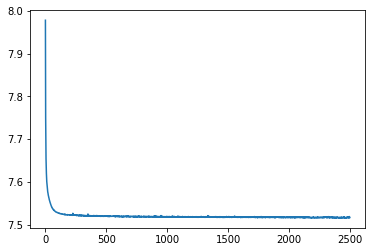

In [ ]:
data: pd.DataFrame = consolidated_dataset.copy().reset_index()
input_feature_count: int = data.shape[1]
netwok_config: list = [
    int(input_feature_count * 1.25),
    int(input_feature_count * 1.10),
    int(input_feature_count * 0.70),
    int(input_feature_count)
]
label_column_names: list = [c for c in data.columns if '__close_next' in c]
model = BifrostNeuralEngine(data=data,
                            labels_column_names=label_column_names,
                            date_column_name='time',
                            layers_config=netwok_config) \
    .fit(epochs=15000)

## Save the Model

In [ ]:
# TODO:

## Make Predictions

In [ ]:
# TODO: